In [32]:
import operator
import os
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
BASE_URL = os.getenv("BASE_URL")

In [37]:
model = ChatOpenAI(
    model="Qwen/Qwen2.5-7B-Instruct",
    api_key=API_KEY,
    base_url=BASE_URL
)

class AgentState(MessagesState):
    selected_tool: str
    tool_result: str
    tool_status: str

# tool selection node
def select_tool(state: AgentState):
    user_message = state["messages"][-1].content
    prompt = ChatPromptTemplate.from_template("""
    You are a tool selection assistant.
    Given the user message, classify it into one of these tools:
    - search_engine
    - calculator
    If none apply, respond with "No tool".

    User message: {message}
    """)
    chain = prompt | model
    response = chain.invoke({"message": user_message})
    tool = response.content.strip().lower()
    # Return updated state
    return {
        "messages": [AIMessage(content=f"selected_tool: {tool}")],
        "selected_tool": tool
    }

# -------------------------------
# TOOL EXECUTION NODES
# -------------------------------
import random

def search_engine_node(state: AgentState):
    user_message = state["messages"][-1].content

    # 随机生成失败
    if random.random() < 0.5:
        error_msg = f"[Search Engine Node] ❌ Failed to fetch results for: {user_message}"
        print(error_msg)
        return {
            "tool_status": "error",
            "tool_result": error_msg,
            "messages": [AIMessage(content=error_msg)]
        }

    # 成功分支
    result = f"[Search Engine Node] ✅ Search results for: {user_message}"
    print(result)
    return {
        "tool_status": "success",
        "tool_result": result,
        "messages": [AIMessage(content=result)]
    }


def calculator_node(state: AgentState):
    user_message = state["messages"][-1].content

    # 随机生成失败
    if random.random() < 0.5:
        error_msg = f"[Calculator Node] ❌ Failed to calculate expression: {user_message}"
        print(error_msg)
        return {
            "tool_status": "error",
            "tool_result": error_msg,
            "messages": [AIMessage(content=error_msg)]
        }

    # 成功分支
    result = f"[Calculator Node] ✅ Calculated result for {user_message}"
    print(result)
    return {
        "tool_status": "success",
        "tool_result": result,
        "messages": [AIMessage(content=result)]
    }

# -------------------------------
# ROUTING FUNCTIONS
# -------------------------------
def route_after_tool_selection(state):
    tool_name = state.get("selected_tool", "").strip().lower()
    mapping = {
        "search_engine": "search_engine_node",
        "calculator": "calculator_node"
    }
    return mapping.get(tool_name, END)

def route_after_tool_execution(state):
    tool_status = state["tool_status"]
    if tool_status == "success":
        return "tool_result_processing_node"
    else:
        return "tool_error_handling_node"

# -------------------------------
# RESULT & ERROR HANDLING NODES
# -------------------------------
def tool_result_processing_node(state: AgentState):
    result = state.get("tool_result", "")
    print(f"[Tool result processing Node] => {result}")
    message = f"✅ Tool execution completed. Here is your result:\n{result}"
    return {
        "messages": [AIMessage(content=message)]
    }

def tool_error_handling_node(state: AgentState):
    result = state.get("tool_result", "")
    return {
        "messages": [AIMessage(content=f"There was an error executing the tool: {result}")]
    }



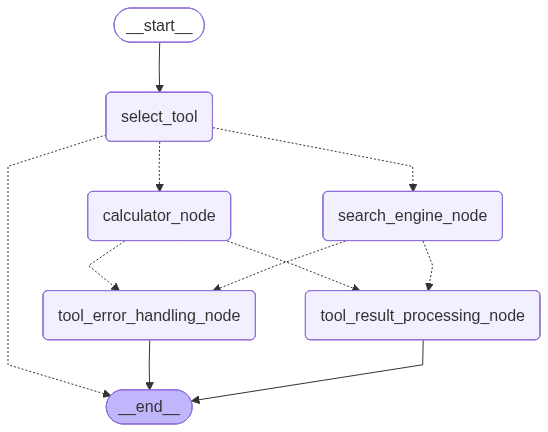

In [38]:
# 构建图
workflow = StateGraph(AgentState)
workflow.add_node("select_tool", select_tool)
workflow.add_node("search_engine_node", search_engine_node)
workflow.add_node("calculator_node", calculator_node)
workflow.add_node("tool_result_processing_node", tool_result_processing_node)
workflow.add_node("tool_error_handling_node", tool_error_handling_node)

workflow.add_edge(START, "select_tool")

# Conditional edges
workflow.add_conditional_edges("select_tool",
                               route_after_tool_selection,
                               {
                                   "search_engine_node": "search_engine_node",
                                   "calculator_node": "calculator_node",
                                   END: END,
                               },)
workflow.add_conditional_edges("search_engine_node",
                               route_after_tool_execution,
                               {
                                   "tool_result_processing_node": "tool_result_processing_node",
                                   "tool_error_handling_node": "tool_error_handling_node",
                               },)
workflow.add_conditional_edges("calculator_node",
                               route_after_tool_execution,
                               {
                                   "tool_result_processing_node": "tool_result_processing_node",
                                   "tool_error_handling_node": "tool_error_handling_node",
                               },)

workflow.add_edge("tool_result_processing_node", END)
workflow.add_edge("tool_error_handling_node", END)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"messages": [HumanMessage(content="find me some books")]})

# The model stores conversation messages cumulatively, so the last one is your final output.
final_message = result["messages"][-1].content
print("----- FINAL OUTPUT -----")
print(final_message)

# Optionally, you can print the raw tool result for debugging:
if "tool_result" in result:
    print("\n----- TOOL RESULT VALUE -----")
    print(result["tool_result"])

----- FINAL OUTPUT -----
selected_tool: no tool
